In [3]:
import numpy as np

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


# Numerical integration with variable-step methods

Previously, we encountered fixed-step integrators, which take steps towards the solution of an initial value problem using a fixed time step $\Delta t$. In this notebook, we will explore variable-step integrators, which take steps of varying size to achieve a desired accuracy.


### Relationship to optimization

In optimization, we saw second-order methods like Newton's method, in which the gradient descent step scales inversely with the local concavity. In numerical integration, we will see methods that scale inversely with the local smoothness. This is a common theme in numerical methods: we want to take steps that are inversely proportional to the local smoothness of the problem.

In [ ]:
class RK4VariableStep:

    def __init__(self, f, x0, t0, dt0, dt_min, dt_max, tol, max_steps=10000):
        self.f = f
        self.x = x0
        self.t = t0
        self.dt = dt0
        self.dt_min = dt_min
        self.dt_max = dt_max
        self.tol = tol
        self.max_steps = max_steps
        self.n_steps = 0

    def step(self):
        f = self.f
        t = self.t
        x = self.x
        dt = self.dt
        k1 = dt * f(t, x)
        k2 = dt * f(t + dt / 2, x + k1 / 2)
        k3 = dt * f(t + dt / 2, x + k2 / 2)
        k4 = dt * f(t + dt, x + k3)
        x_new = x + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        err = np.max(np.abs(x_new - x))
        if err < self.tol:
            self.x = x_new
            self.t += dt
            self.n_steps += 1
            if self.dt < self.dt_max:
                self.dt *= 2
        else:
            if self.dt > self.dt_min:
                self.dt /= 2
        return err

    def integrate(self):
        err = 1
        while err > self.tol and self.n_steps < self.max_steps:
            err = self.step()
        return self.t, self.x


# Symplectic

When we have an explict conserved quantity, many of the above methods will fail



In [ ]:
class ThreeBody:

    def __init__(self, m1, m2, m3, G=1):
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.G = G

    def __call__(self, t, x):
        m1 = self.m1
        m2 = self.m2
        m3 = self.m3
        G = self.G
        x1 = x[0:3]
        x2 = x[3:6]
        x3 = x[6:9]
        v1 = x[9:12]
        v2 = x[12:15]
        v3 = x[15:18]
        r12 = x2 - x1
        r13 = x3 - x1
        r23 = x3 - x2
        r12_mag = np.sqrt(np.sum(r12 ** 2))
        r13_mag = np.sqrt(np.sum(r13 ** 2))
        r23_mag = np.sqrt(np.sum(r23 ** 2))
        a1 = G * m2 / r12_mag ** 3 * r12 + G * m3 / r13_mag ** 3 * r13
        a2 = G * m1 / r12_mag ** 3 * -r12 + G * m3 / r23_mag ** 3 * r23
        a3 = G * m1 / r13_mag ** 3 * -r13 + G * m2 / r23_mag ** 3 * -r23
        return np.concatenate((v1, v2, v3, a1, a2, a3))

In [25]:
class SimplePendulum:

    def __init__(self, g=9.82, l=1.0):
        self.g = g
        self.l = l

    def __call__(self, t, x):
        g = self.g
        l = self.l
        theta, omega = x
        dtheta = omega
        domega = -g / l * np.sin(theta)
        return np.array([dtheta, domega])

pendulum = SimplePendulum()

from scipy.integrate import solve_ivp

# Initial conditions
x0 = np.array([np.pi / 2, 0.0])
t0 = 0.0

# solve ivp

# Set up integrator
integrator = solve_ivp(pendulum, [t0, 2000], x0, method='RK45', max_step=1e-2)

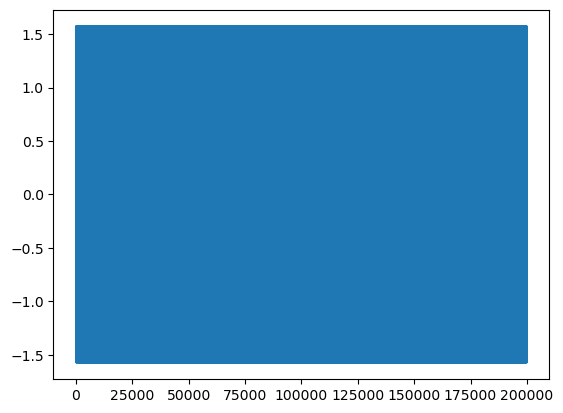

In [24]:
plt.plot(integrator.y[0, :])

# Stochastic differential equations

What if our differential equation has a stochastic component? We can use the same methods as before, but we need to take into account the stochastic component. We will use the Euler-Maruyama method, which is a first-order method for stochastic differential equations. The method is given by

$$
\begin{align}
\mathbf{x}_{n+1} &= \mathbf{x}_n + \Delta t\; \mathbf{f}(\mathbf{x}_n) + \sqrt{\Delta t}\; g(\mathbf{x}_n) \xi_n \\
\xi_n &\sim \mathcal{N}(0, 1)
\end{align}
$$

+ Notice that this is similar to how we implemented Ornstein-Uhlenbeck dynamics earlier in the course. We are just replacing the harmonic oscillator forcing with our general right hand side. 
+ We scale our noise term by $\sqrt{\Delta t}$. Recall that Brownian motion has a mean *square* displacement that scales as $\Delta t$, which corresponds to the average distance from origin scaling as $\sqrt{t}$.


+ Nice discussion of various methods by [Tim Sauer here](https://math.gmu.edu/~tsauer/pre/sde.pdf)


In [ ]:
class EulerMaruyamaVariableStep:

    def __init__(self, f, g, x0, t0, dt0, dt_min, dt_max, tol, max_steps=10000):
        self.f = f
        self.g = g
        self.x = x0
        self.t = t0
        self.dt = dt0
        self.dt_min = dt_min
        self.dt_max = dt_max
        self.tol = tol
        self.max_steps = max_steps
        self.n_steps = 0

    def update(self):
        f = self.f
        g = self.g
        t = self.t
        x = self.x
        dt = self.dt
        x_new = x + dt * f(t, x) + np.sqrt(dt) * g(t, x)
        err = np.max(np.abs(x_new - x))
        if err < self.tol:
            self.x = x_new
            self.t += dt
            self.n_steps += 1
            if self.dt < self.dt_max:
                self.dt *= 2
        else:
            if self.dt > self.dt_min:
                self.dt /= 2
        return err

    def integrate(self):
        err = 1
        while err > self.tol and self.n_steps < self.max_steps:
            err = self.update()
        return self.t, self.x

In [ ]:
class StochasticRungeKutta4VariableStep:

    def __init__(self, f, g, x0, t0, dt0, dt_min, dt_max, tol, max_steps=10000):
        self.f = f
        self.g = g
        self.x = x0
        self.t = t0
        self.dt = dt0
        self.dt_min = dt_min
        self.dt_max = dt_max
        self.tol = tol
        self.max_steps = max_steps
        self.n_steps = 0

    def update(self):
        f = self.f
        g = self.g
        t = self.t
        x = self.x
        dt = self.dt
        k1 = dt * f(t, x)
        k2 = dt * f(t + dt / 2, x + k1 / 2)
        k3 = dt * f(t + dt / 2, x + k2 / 2)
        k4 = dt * f(t + dt, x + k3)
        x_new = x + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        err = np.max(np.abs(x_new - x))
        if err < self.tol:
            self.x = x_new
            self.t += dt
            self.n_steps += 1
            if self.dt < self.dt_max:
                self.dt *= 2
        else:
            if self.dt > self.dt_min:
                self.dt /= 2
        return err

    def integrate(self):
        err = 1
        while err > self.tol and self.n_steps < self.max_steps:
            err = self.update()
        return self.t, self.x